# Deep ensemble for ENSO-forecasting

In this tutorial you learn how to use a neural network model called Deep Ensemble (DE) for the ENSO forecasting. This network architecture was initially developed [Lakshminarayanan et al. (2017)](https://papers.nips.cc/paper/7219-simple-and-scalable-predictive-uncertainty-estimation-using-deep-ensembles.pdf). 

DEs are feed foreword neural networks that predict the mean and the standard deviation of a Gaussian. Hence, their predicion comes with an uncertainty estimation which is a valuable feature for ENSO-forecasting.

## Create a data pipe line

At first, we define a data pipeline. This is in general quite useful to keep your code clean and also to reuse the pipeline for later purpose.

The data pipeline generates returns:

1. The feature array

2. The label array

3. The time  array corresponding to the time of the label

NOTE (again): Lead time is defined as the time that passed between the last observed and the first date of the target season. Hence, negative appear, e.g. if you compare the DJF season with the target season JFM, you have a lead time of -2 month (Last observed date: Feburary 28/29, First date of the target season January 1).

In [2]:
from ninolearn.IO.read_processed import data_reader
from ninolearn.IO.read_raw import ZC_simple_read
import numpy as np
import pandas as pd

oneyear= pd.Timedelta(365, 'D')

%load_ext autoreload

%autoreload 2

In [3]:
version = 'mu34v3'
leadtime = 12

# t_start is defined using a funky timedelta because the starting date of the network analysis data is the last month
# of its start year which is 1951-12 therefore the time must start in 1952 with some months added for values lost in 
# interpolation. TODO: fix this by backwards interpolating the first values of the year and finding out what is happening 
# with the nms
times = np.unique(ZC_simple_read(version)['time'])

t_start = times[0] + pd.Timedelta((2*365 + 90),'D')
t_end = times[-1] - pd.Timedelta(90,'D')

print(f'tstart = {t_start} and tend = {t_end}')


tstart = 1952-04-07 14:17:30 and tend = 1994-08-26 03:33:20


using dimensions ('lat', 'lon') from data variable temperature as the horizontal dimensions for this dataset.


/home/ivo/anaconda3/envs/ninolearn/lib/python3.6/site-packages/xesmf/frontend.py:524: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ivo/anaconda3/envs/ninolearn/lib/python3.6/site-packages/xesmf/smm.py:93: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


- Read sst climatetology
using dimensions ('lat', 'lon') from data variable temperature as the horizontal dimensions for this dataset.


/home/ivo/anaconda3/envs/ninolearn/lib/python3.6/site-packages/xesmf/frontend.py:524: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


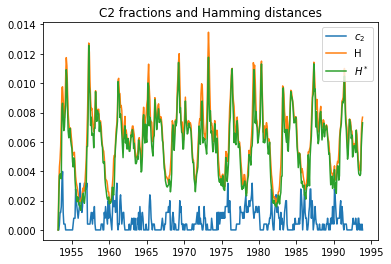

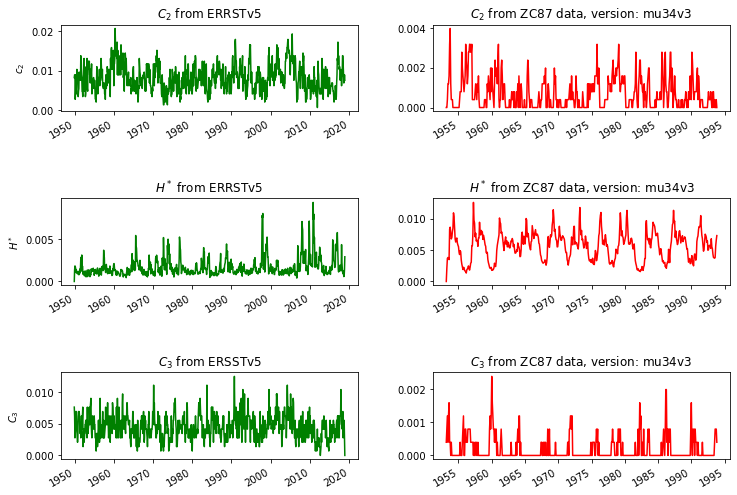

In [4]:
from ninolearn.IO.read_raw import ZC_raw, ZC_h, ZC_oni
from ninolearn.preprocess.prepare import prep_nms
from ninolearn.plot.ZC_dem_plots import nms_plots
## read raw ZC data and save to 1x1 grid file in processeddir
## also makes field of h and sst
ZC_raw(version)

## calculates monthly averaged (?) fields of thermocline height within region 
## of interest. cacluate ONI in region of interest. calculate network metrics 
## from sst (Henk's suggestion) or thermocline height (like Paul)
ZC_h(version) 
ZC_oni(version)
prep_nms(version, 0.99, t_start, t_end)

# make plots
nms_plots(version)


In [5]:

reader = data_reader(startdate=(t_start + pd.Timedelta(365,'D')) , enddate=(t_end - pd.Timedelta(2*365, 'D')) , lon_min = 124, lon_max = 280,
                         lat_min = -19, lat_max = 19)

oni = reader.read_csv(('oni_ZC_' +version))
h = reader.read_csv(('h_mean_ZC_' + version))

network_ssh = reader.read_statistic('network_metrics', variable='sst', dataset=('ZC_25x25_' + version), processed="anom")
c2 = network_ssh['fraction_clusters_size_2']
H = network_ssh['corrected_hamming_distance']


In [6]:
if h.shape[0] + c2.shape[0] - H.shape[0] - oni.shape[0] == 0:
    print('All datasets are of equal length')

All datasets are of equal length


In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler

from ninolearn.utils import include_time_lag
from ninolearn.IO.read_processed import data_reader


def pipeline(lead_time):
    """
    Data pipeline for the processing of the data before the Deep Ensemble
    is trained.

    :type lead_time: int
    :param lead_time: The lead time in month.

    :returns: The feature "X" (at observation time), the label "y" (at lead
    time), the target season "timey" (least month)
    """
#     reader = data_reader(startdate='1952-01', enddate='1992-12', lon_min = 124, lon_max = 280,
#                          lat_min = -19, lat_max = 19)
    reader = data_reader(startdate=(t_start + oneyear), enddate=(t_end - 2*oneyear), lon_min = 124, lon_max = 280,
                         lat_min = -19, lat_max = 19)

    # indeces
    oni = reader.read_csv(('oni_ZC_' +version))
    h = reader.read_csv(('h_mean_ZC_' + version))
    #IOD unavailable in ZC87 model 
    
    # seasonal cycle
    sc = np.cos(np.arange(len(oni))/12*2*np.pi)

    # network metrics
    network_ssh = reader.read_statistic('network_metrics', variable='sst', dataset=('ZC_25x25_'+version), processed="anom")
    c2 = network_ssh['fraction_clusters_size_2']
    H = network_ssh['corrected_hamming_distance']

    # time lag
    time_lag = 12

    # shift such that lead time corresponds to the definition of lead time
    shift = 3

    # process features
    feature_unscaled = np.stack((oni, h,
                                 c2, H), axis=1)

    # scale each feature
    scalerX = StandardScaler()
    Xorg = scalerX.fit_transform(feature_unscaled)

    # set nans to 0.
    Xorg = np.nan_to_num(Xorg)

    # arange the feature array
    X = Xorg[:-lead_time-shift,:] # this chops of a bit at the end because matching labels will be offset by 
    # this amount. e.g. if our data runs until 2012 we need to remove X values for 2012 because we will use december 2011
    # to predict december 2012 
    
#     X = include_time_lag(X, max_lag=time_lag)
    X = include_time_lag(X, n_lags =time_lag)  # staggers the data with 1 month shifts so at each moment of input also
    # nlags amount of months before is available to the AI

    # arange label
    yorg = oni.values
    y = yorg[lead_time + time_lag + shift:] # labels offset by lead_time to predict into the future and time_lag 
    # because the include_time_lag function shifts X values forward by an amount n_lags=time_lag

    # get the time axis of the label
    timey = oni.index[lead_time + time_lag + shift:]

    return X, y, timey

## Split the data set

For the training and testing of machine learning models it is crucial to split the data set into:

1. __Train data set__ which is used to train the weights of the neural network

2. __Validation data set__ which is used to check for overfitting (e.g. when using early stopping) and to optimize the hyperparameters 

3. __Test data set__ which is used to to evaluate the trained model. 

__NOTE:__ It is important to understand that hyperparamters must be tuned so that the result is best for the Validation data set and __not__ for the test data set. Otherwise you can not rule out the case that the specific hyperparameter setting just works good for the specific test data set but is not generally a good hyperparameter setting.

In the following cell the train and the validation data set are still one data set, because this array will be later splitted into two arrays when th model is fitted.

In [8]:
import keras.backend as K
from ninolearn.learn.models.dem import DEM

# clear memory from previous sessions
K.clear_session()

# define the lead time
lead_time = leadtime

# get the features (X), the label (y) and 
# the time axis of the label (timey)
X, y, timey = pipeline(lead_time)

# split the data set into 
# test_indeces = (timey>='1987-01-01') & (timey<='1993-12-01')
test_indeces = (timey>=t_end - pd.Timedelta(5*365, 'D')) & (timey<=t_end)

train_val_indeces = np.invert(test_indeces)

train_val_X, train_val_y, train_val_timey = X[train_val_indeces,:], y[train_val_indeces], timey[train_val_indeces]
testX, testy, testtimey = X[test_indeces,:], y[test_indeces], timey[test_indeces]


In [9]:
print(y.shape, X.shape, timey.shape)
print('shapes of the data, labels and time axis is predictable, since there are now 4 features and 12 lags \
    making for 48 columns. The labels are offset from the input data by the lead time ')
      

(445,) (445, 48) (445,)
shapes of the data, labels and time axis is predictable, since there are now 4 features and 12 lags     making for 48 columns. The labels are offset from the input data by the lead time 


## Fit the model

Now it is time to train the model! For this a random search is used for all keyword arguments that are passed in a *list* to the DEM.set_parameters() method. 

In [10]:
# # initiated an instance of the DEM (Deep Ensemble Model) class
# model = DEM()

# # Set parameters
# model.set_hyperparameters(searchtype='linear', layers=1, neurons=16, dropout=[0.1, 0.5], noise_in=[0.1,0.5], noise_sigma=[0.1,0.5],
#                      noise_mu=[0.1,0.5], l1_hidden=[0.0, 0.2], l2_hidden=[0., 0.2],
#                      l1_mu=[0.0, 0.2], l2_mu=[0.0, 0.2], l1_sigma=[0.0, 0.2],
#                      l2_sigma=[0.0, 0.2], lr=[0.0001,0.01], batch_size=100, epochs=500, n_segments=5,
#                      n_members_segment=1, patience=30, verbose=0, pdf='normal', activation = 'relu')

# # Use a random search to find the optimal hyperparameters

# model.fit_RandomizedSearch(train_val_X, train_val_y, train_val_timey, n_iter=20)

In [13]:
from ninolearn.learn.fit import cross_training


cross_training(DEM, pipeline, n_iter = 1 , dropout=[0.1, 0.5], noise_in=[0.1,0.5], noise_sigma=[0.1,0.5],
                     noise_mu=[0.1,0.5], l1_hidden=[0.0, 0.2], l2_hidden=[0., 0.2],
                     l1_mu=[0.0, 0.2], l2_mu=[0.0, 0.2], l1_sigma=[0.0, 0.2],
                     l2_sigma=[0.0, 0.2], lr=[0.0001,0.01])
# cross_training(DEM, pipeline, n_iter = 5)


##################################################################
Lead time: 0 month
##################################################################

Test period: 1953-01-01 till 1961-12-01
--------------------------------------
Search iteration Nr 1/1
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
3/3 [==============================] - 0s 8ms/step - loss: 5.1085 - nll_gaussian: 0.4622
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
3/3 [==============================] - 0s 10ms/step - loss: 16.0419 - nll_gaussian: 0.6147
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 3.8827 - nll_gaussian: 0.3817
bu


##################################################################
Lead time: 6 month
##################################################################

Test period: 1953-01-01 till 1961-12-01
--------------------------------------
Search iteration Nr 1/1
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 4.0114 - nll_gaussian: 0.2081
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
3/3 [==============================] - 0s 1ms/step - loss: 2.5242 - nll_gaussian: 0.6030
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
3/3 [==============================] - 0s 11ms/step - loss: 2.6629 - nll_gaussian: 0.4874
bui


##################################################################
Lead time: 12 month
##################################################################

Test period: 1953-01-01 till 1961-12-01
--------------------------------------
Search iteration Nr 1/1
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 8.4944 - nll_gaussian: 0.3684
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 7.3433 - nll_gaussian: 1.3698
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 4.9888 - nll_gaussian: 0.7503
bui


##################################################################
Lead time: 18 month
##################################################################

Test period: 1953-01-01 till 1961-12-01
--------------------------------------
Search iteration Nr 1/1
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 4.1798 - nll_gaussian: 0.6785
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 5.9297 - nll_gaussian: 0.5364
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 5.8704 - nll_gaussian: 0.4704
bui

In [15]:
from ninolearn.learn.fit import cross_hindcast_dem

cross_hindcast_dem(DEM, pipeline, 'dem')

updated code #2 (!)

##################################################################
Lead time: 0 months
##################################################################

Predict: 1953-01-01 till 1961-12-01
--------------------------------------


TypeError: get_model_desc() missing 1 required positional argument: 'pdf'

## Make predictions for the test data set
Now we can use the trained models to make predicitons on the test data set to evaluate how good the model perfoms on a data set that it never saw before.

In [ ]:
pred_mean, pred_std = model.predict(testX)

In [ ]:
# from ninolearn.learn.fit import cross_hindcast_dem, cross_hindcast
# cross_hindcast(model, pipeline, 'DEM')
# # cross_hindcast_dem(model, pipeline, 'DEM')

## Plot the prediction
Let's see how the predicion is looking like

In [ ]:
import matplotlib.pyplot as plt
from ninolearn.plot.prediction import plot_prediction
import pandas as pd
from ninolearn.pathes import plotdir

from os.path import join


plt.subplots(figsize=(15,3.5))
plt.axhspan(-0.5,
            -6,
            facecolor='blue',
            alpha=0.1,zorder=0)

plt.axhspan(0.5,
            6,
            facecolor='red',
            alpha=0.1,zorder=0)

plt.xlim(testtimey[0], testtimey[-1])
plt.ylim(-3,3)

# plot the prediction
plot_prediction(testtimey, pred_mean, std=pred_std, facecolor='royalblue', line_color='navy')

# plot the observation
plt.plot(timey, y, "r", label = 'observation')
plt.legend()

plt.savefig(join(plotdir, f'predicVSobs_{version}_{lead_time}lead'))

plt.show()

## Evaluate the model

We can evaluate the model a bit more quantitatively using the loss function that was used to train the model, namely the negative-log-likelihood of the Gaussian and the correlation between the predicted mean and the observed ONI index.

In [ ]:
from ninolearn.plot.evaluation import plot_correlation, plot_confMat, plot_seasonal_skill

loss = model.evaluate(testy, pred_mean, pred_std)
print(f"Loss (Negative-Log-Likelihood): {loss}")

# make a plot of the seasonal correaltion
# note: - pd.tseries.offsets.MonthBegin(1) appears to ensure that the correlations are plotted
# agains the correct season
plot_correlation(testy, pred_mean, testtimey - pd.tseries.offsets.MonthBegin(1), title="")

# plot_seasonal_skill(leadtime, r_seas)

# plt.savefig(join(plotdir, f'correlation_{version}_{lead_time}lead'))






In [ ]:
cross_hindcast_dem(model, pipeline, 'DEM')


In [ ]:
from ninolearn.learn.fit import n_decades, lead_times, decade_color, decade_name
from ninolearn.learn.evaluation import evaluation_correlation, evaluation_decadal_correlation, evaluation_seasonal_correlation
from ninolearn.learn.fit import cross_hindcast_dem

cross_hindcast_dem(model, pipeline, 'DEM')

r_seas, p_seas = evaluation_seasonal_correlation('DEM', variable_name='prediction')

plot_seasonal_skill(lead_times, r_seas,  vmin=0, vmax=1)
plt.contour(np.arange(1,13),lead_times, p_seas, levels=[0.01, 0.05, 0.1], linestyles=['solid', 'dashed', 'dotted'], colors='k')
plt.title('Correlation skill')
plt.tight_layout()